In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import cv2 as cv
import glob, os
import shutil

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.utils import class_weight

In [3]:
import keras
from keras import backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from keras.utils import np_utils

/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%matplotlib inline
K.set_image_data_format('channels_last')

In [5]:
PATH_TO_CROPPED_IMAGES = '../images/cropped/'
PATH_TO_LABELS = '../annotations/cropped_color_label.csv'
CLASSES = 6
H, W, CH = 36, 64, 3

In [6]:
def get_model():
    
    K.clear_session()
    sess = tf.Session()
    K.set_session(sess)

    
    x = Input((H, W, CH))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 8, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 8, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 8, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 8, kernel_size = (3,3),
                          strides = (1,1), padding = 'same', activation='relu')(model)
    model = Dropout(0.2)(model)
    model = GlobalAveragePooling2D()(model)
 
    model = Dense(CLASSES, activation = 'softmax')(model)
    
    model = Model(inputs = x, outputs = model)
    
    opt_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(opt_adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [7]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 64, 8)         224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 64, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 32, 8)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 32, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 32, 8)         584       
__________

In [8]:
# load labels
df = pd.read_csv(PATH_TO_LABELS)
df.head(6)

,filename,label,color
0,000_pic.JPG,5,Blue
1,001_pic.JPG,3,White
2,002_pic.JPG,1,Green
3,003_pic.JPG,6,Red
4,004_pic.JPG,2,Yellow
5,005_pic.JPG,4,Gray


In [9]:
def label_to_color(label):
    """
    can get int or array
    """
    dic = {1: 'Green', 2:'Yellow', 3:'White', 4:'Gray', 5:'Blue', 6:'Red'}
    if (label.dtype == np.dtype('int64')):
        return dic[label]
    else:
        return dic[np.argmax(label)+1]

In [10]:
# load data - cropped images and labels
X = []
y = []
for _, row in df.iterrows():
    img = cv.imread(os.path.join(PATH_TO_CROPPED_IMAGES, row['filename']))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (W, H))
    X.append(img)
    y.append(row['label'])

X = np.asarray(X)
y = np.asarray(y)

In [11]:
print(X.shape)

(104, 36, 64, 3)


In [12]:
# classes summary - not balanced! 
# TODO: balance it.
for i in range(CLASSES):
    c = np.int64(i+1)
    c = label_to_color(c)
    print('Class {}: {}'.format(c, np.sum(y == (i+1))))

Class Green: 18
Class Yellow: 22
Class White: 13
Class Gray: 12
Class Blue: 19
Class Red: 20


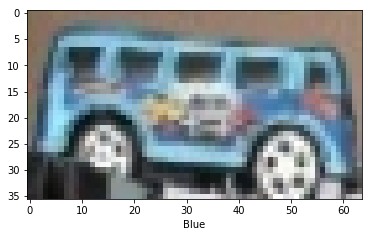

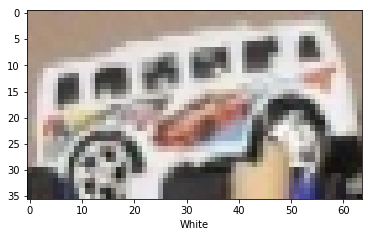

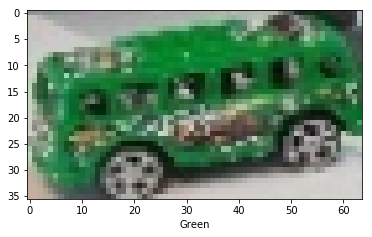

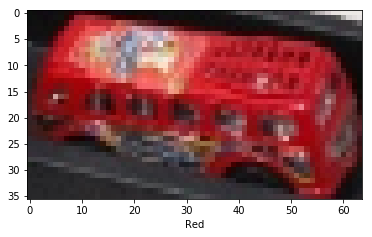

In [13]:
# view n images
n = 4
for img, lab in zip(X[:n], y[:n]):
    plt.figure()
    plt.xlabel(label_to_color(lab))
    plt.imshow(img)

In [ ]:
# 1-fold basic example
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [14]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 90,
                         shear_range=0.2,
                         brightness_range=(0.8, 1.2)
                        )

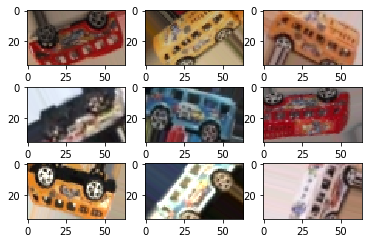

In [15]:
# Check augmentation
gen.fit(X)
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in gen.flow(X, y, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(int))
    # show the plot
    plt.show()
    break

In [16]:
def get_callbacks(fold, patience_lr):
    
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.995, min_lr=1e-5, cooldown=5, min_delta=1e-7,
                                       patience=patience_lr, verbose=0, mode='min')
    
    tb = keras.callbacks.TensorBoard(log_dir='./Graph/fold-{}/'.format(fold), batch_size=batch_size,
                                     write_graph=True, write_images=True, write_grads=True)
    
    #early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5, verbose=0, mode='auto')
    
    #weights_cp = LambdaCallback(on_epoch_end=lambda epoch, logs: model.save_weights(filepath='./weights/weights.fold_{}_epoch_{:04d}_val_acc_{:.2f}.hdf5'.format(fold, epoch, logs['val_acc'])))

    return [reduce_lr_loss, tb]

In [17]:
k = 10
folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

In [18]:
j = 1
enc = OneHotEncoder(sparse=False)
y_onehot = enc.fit_transform(y.reshape(-1, 1))
batch_size = 16


if os.path.isdir('./Graph/'):
    shutil.rmtree('./Graph/')

for train_idx, val_idx in folds.split(X,y):
    
    
    print('\nFold ',j)
    # divide the input data
    X_train_cv = X[train_idx]
    X_valid_cv = X[val_idx]
    
    # devide the labels and convert to one hot encoding
    y_train_cv = y[train_idx]
    # weight classes to compensate imbalanced 
    weights = class_weight.compute_class_weight('balanced', np.unique(y_train_cv), y_train_cv)
    y_train_cv = enc.fit_transform(y_train_cv.reshape(-1, 1))
    
    y_valid_cv= y[val_idx]
    y_valid_cv = enc.fit_transform(y_valid_cv.reshape(-1, 1))
        
    callbacks = get_callbacks(j, patience_lr=10)
    j += 1
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    history = model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=1000,
                shuffle=True,
                verbose=0,
                validation_data = (X_valid_cv, y_valid_cv),
                class_weight=2-weights,
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
    
    break


Fold  1


/home/sha_maayan/python-environments/env/lib/python3.5/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


13/13 [==============================] - 0s 246us/step
[0.569463312625885, 0.8461538553237915]


In [19]:
# eval all data (base on the last model only!)
y_onehot = y.copy()
y_onehot = enc.fit_transform(y_onehot.reshape(-1, 1))
model.evaluate(X, y_onehot)

104/104 [==============================] - 0s 317us/step


[0.45527859376027036, 0.8557692307692307]

In [20]:
# predict all images
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=1)+1

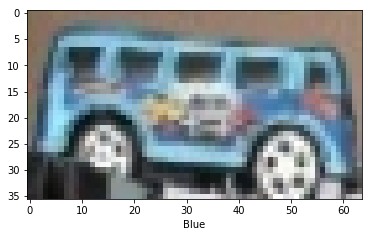

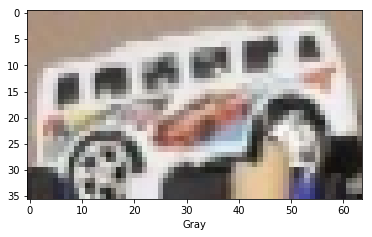

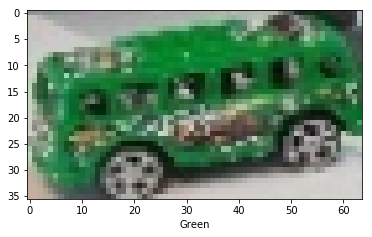

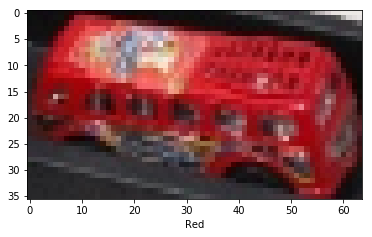

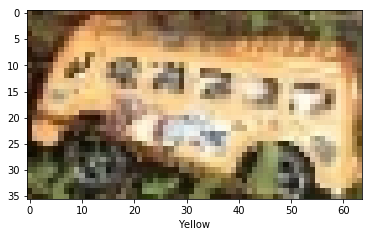

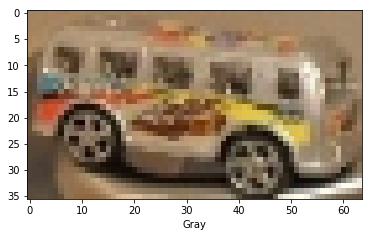

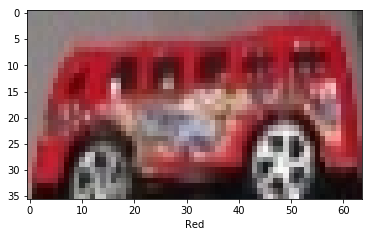

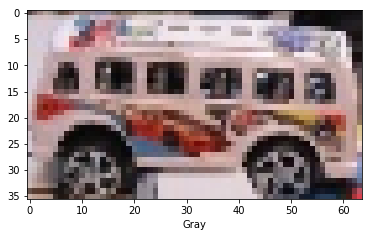

In [21]:
# print n predictions
n = 8
for img, lab in zip(X[:n], y_pred[:n]):
    plt.figure()
    plt.xlabel(label_to_color(lab))
    plt.imshow(img)

In [22]:
print(metrics.precision_score(y, y_pred, average='macro'))
print(metrics.recall_score(y, y_pred, average='micro'))
print(metrics.f1_score(y, y_pred, average='weighted'))

0.8946488294314382
0.8557692307692307
0.8484144940027293


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18  0  0  0  0  0]
 [ 0 22  0  0  0  0]
 [ 0  0  4  9  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  2 17  0]
 [ 0  4  0  0  0 16]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.31 0.69 0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.11 0.89 0.  ]
 [0.   0.2  0.   0.   0.   0.8 ]]


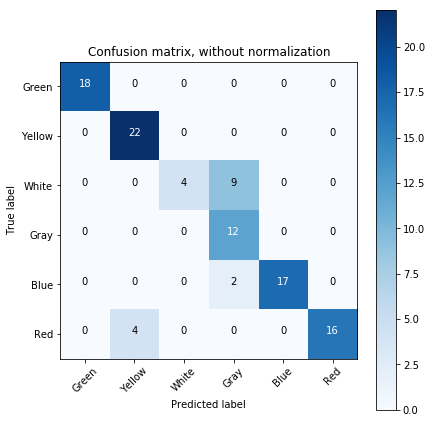

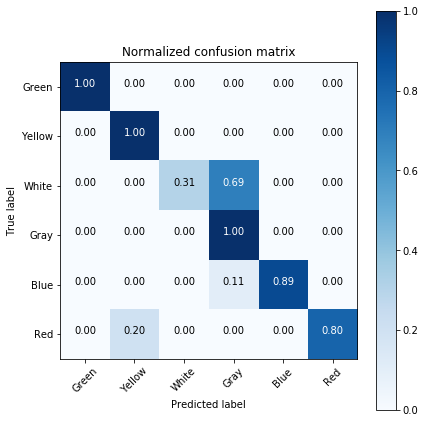

In [24]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
class_names = ['Green', 'Yellow', 'White', 'Gray', 'Blue', 'Red']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()